Epoch 1/30
56322/56322 [==============================] - 161s - loss: 0.0482 - val_loss: 0.0458
Epoch 2/30
56322/56322 [==============================] - 158s - loss: 0.0215 - val_loss: 0.0440
Epoch 3/30
56322/56322 [==============================] - 159s - loss: 0.0191 - val_loss: 0.0433
Epoch 4/30
56322/56322 [==============================] - 159s - loss: 0.0175 - val_loss: 0.0407
Epoch 5/30
56322/56322 [==============================] - 160s - loss: 0.0162 - val_loss: 0.0363
Epoch 6/30
56322/56322 [==============================] - 160s - loss: 0.0151 - val_loss: 0.0325
Epoch 7/30
56322/56322 [==============================] - 160s - loss: 0.0140 - val_loss: 0.0290
Epoch 8/30
56322/56322 [==============================] - 161s - loss: 0.0129 - val_loss: 0.0266
Epoch 9/30
56322/56322 [==============================] - 160s - loss: 0.0119 - val_loss: 0.0246
Epoch 10/30
56322/56322 [==============================] - 160s - loss: 0.0112 - val_loss: 0.0235
Epoch 11/30
56322/56322 [====

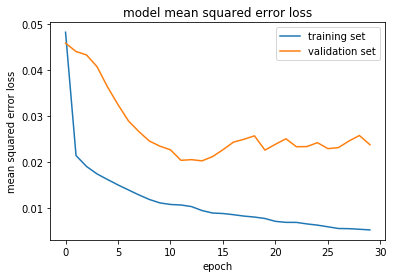

In [12]:
import sklearn
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, BatchNormalization, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

#read the CSV file
samples = []
with open('./data/driving_log_merged.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
#Pop out the first line containing column labels
samples.pop(0)

#generator function for generating batches
def generator(samples, batch_size=64):
    num_samples = len(samples)
    correction = 0.20
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                #images are augmented with left/right camera angles
                center_name = './data/IMG/'+batch_sample[0].split('/')[-1]
                left_name = './data/IMG/'+batch_sample[1].split('/')[-1]
                right_name = './data/IMG/'+batch_sample[2].split('/')[-1]
                center_image = cv2.imread(center_name)
                left_image = cv2.imread(left_name)
                right_image = cv2.imread(right_name)
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                images.append(center_image)
                angles.append(center_angle)
                images.append(cv2.flip(center_image,1))
                angles.append(center_angle*-1.0)
                images.append(left_image)
                angles.append(left_angle)
                images.append(cv2.flip(left_image,1))
                angles.append(left_angle*-1.0)                
                images.append(right_image)
                angles.append(right_angle)
                images.append(cv2.flip(right_image,1))
                angles.append(right_angle*-1.0)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
            
#split the data into training and valadation sets            
train_samples, valid_samples = train_test_split(samples, test_size=0.20)

#training/validation variables
train_generator = generator(train_samples, batch_size=150)
valid_generator = generator(valid_samples, batch_size=150)

# I used a model similar to the NVidia self driving car model, with 
# the addition of Batch Normalization layers to reduce overfitting
model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

model.add(Convolution2D(24,5,5,subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(36,5,5,subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(48,5,5,subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

#train the model
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*6, validation_data=valid_generator, 
                    nb_val_samples=len(valid_samples)*6, nb_epoch=30)

#save the model
model.save('model.h5')

#plot training history
print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()